In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input,LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
df.head()

,road_segment,datetime,average_speed
0,0,2019-12-23 05:00:00,37.0
1,0,2019-12-05 05:00:02,42.6
2,0,2019-12-12 05:00:04,39.4
3,0,2019-12-29 05:00:04,35.7
4,0,2019-12-12 05:00:05,30.2


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['is_peakhour'] = df['hour'].apply(lambda x: 1 if (8 <= x <= 11 or 16 <= x <= 18) else 0)
df['is_weekend'] = df['datetime'].dt.dayofweek.apply(lambda x: 1 if x == 5 else 0)
df.head()

,road_segment,datetime,average_speed,hour,minute,is_peakhour,is_weekend
0,0,2019-12-23 05:00:00,37.0,5,0,0,0
1,0,2019-12-05 05:00:02,42.6,5,0,0,0
2,0,2019-12-12 05:00:04,39.4,5,0,0,0
3,0,2019-12-29 05:00:04,35.7,5,0,0,0
4,0,2019-12-12 05:00:05,30.2,5,0,0,0


In [6]:
features = ['road_segment','hour', 'minute', 'is_peakhour', 'is_weekend']
target = 'average_speed'

In [7]:
X = df[features].values
y = df[target].values

In [8]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [9]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [12]:
model = Sequential([
    Input(shape=(1, len(features))),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [14]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, 
                    validation_split=0.2, verbose=1)

Epoch 1/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1269 - val_loss: 0.0391
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0330 - val_loss: 0.0188
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0147
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0133
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0129
Epoch 8/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 9/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_loss: 0.0123
Epoch 10/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 11/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 12/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [15]:
model.save('lstm_average_speed.keras')

In [16]:
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss (MSE): {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Test Loss (MSE): 0.005420208442956209


In [17]:
y_pred_scaled = model.predict(X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


In [18]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [19]:
results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred.flatten()})
print(results.head())

   Actual  Predicted
0    18.1  18.960443
1    10.1  19.072332
2    19.0  16.258638
3    16.1  16.981825
4    31.7  28.296877


In [20]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 14.042729975561281


In [21]:
mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 2.8400617036158313


In [22]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 3.747363069621261


In [23]:
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 16.229709882692116%


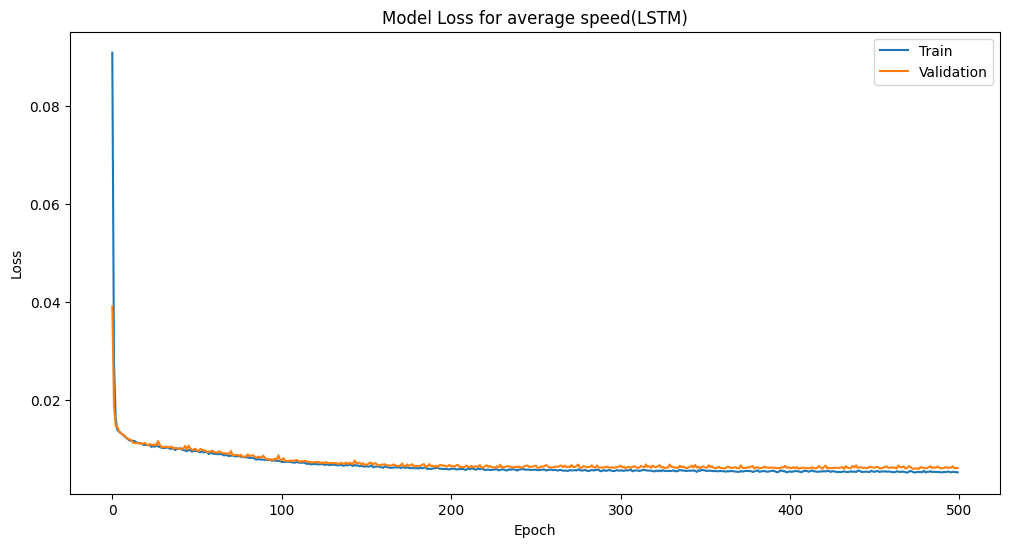

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for average speed(LSTM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('training_validation_loss.png')
plt.show()

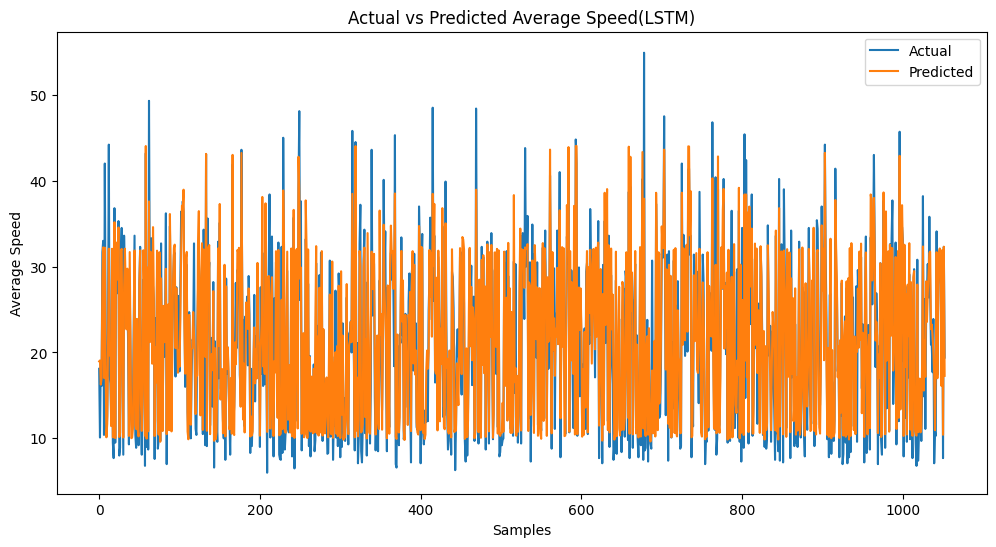

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Average Speed(LSTM)')
plt.xlabel('Samples')
plt.ylabel('Average Speed')
plt.legend()
plt.savefig('Actual vs Predicted Average Speed.png')
plt.show()

In [26]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [27]:
def calculate_accuracy(expected_times, actual_times):
    n = len(expected_times)    
    sum_term = sum(1 - abs((expected_times[i] - actual_times[i]) / actual_times[i]) for i in range(n))
    accuracy = (sum_term / n) * 100
    return accuracy
accuracy = calculate_accuracy(y_test_actual.flatten(), y_pred.flatten())
print(f"Accuracy on Validation Set: {accuracy:.2f}%")

Accuracy on Validation Set: 85.20%
